# Temperature Profile
This looks at a single coordinate, evaluating whether the temperature profile is near moist adiabatic for hottest individual days, or averaged over longer e.g. week.

In [58]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.mpl.ticker as cticker
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import metpy
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils import area_weighting
from isca_tools.utils.base import round_any
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, dry_profile_temp, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7


plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load in data
First load in the temperature profile. Then load in the surface pressure, and compute REFHT variables.

Also, compute the LCL, and lapse rates below and above this.

In [3]:
exp_dir = '/Users/joshduffield/Desktop/'
exp_names = ['russia', 'spain', 'australia']
n_exp = len(exp_names)
ds = [xr.load_dataset(os.path.join(exp_dir, exp_names[i]+'.nd2')) for i in range(n_exp)]
ds = xr.concat(ds, dim=xr.Variable("loc", exp_names))
ds = ds.rename_vars({'TREFHT': 'TS', 'QREFHT': 'QS'})           # rename 2m variables as surface

In [4]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
invariant_data = xr.open_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc')[['PHIS']]
z2m = []
for i in range(n_exp):
    z2m.append(float(invariant_data.PHIS.sel(lat=ds.isel(loc=i).lat, lon=ds.isel(loc=i).lon, method='nearest')/g + 2))
ds['ZS'] = xr.DataArray(z2m, dims=["loc"], coords={"loc": exp_names}, name="z2m")

def get_lev_info(archive_dir='/Users/joshduffield/Documents/StAndrews/Isca/cesm/archive',
                 exp_name='test', year_files=41, hist_file=1):
    # Use test dataset to get
    ds = isca_tools.cesm.load_dataset(exp_name, archive_dir=archive_dir,
                                      hist_file=hist_file, year_files=year_files)
    return ds.hyam.isel(time=0).load(), ds.hybm.isel(time=0).load(), float(ds.P0.isel(time=0))
ds['hyam'], ds['hybm'], p0 = get_lev_info()

In [5]:
refht_level_index = -3
# refht_level_index = None
ds['p'] = isca_tools.cesm.get_pressure(ds.PS, p0, ds['hyam'], ds['hybm'])
if refht_level_index is not None:
    ds['TREFHT'] = ds.T.isel(lev=refht_level_index)
    ds['QREFHT'] = ds.Q.isel(lev=refht_level_index)
    ds['PREFHT'] = ds.p.isel(lev=refht_level_index)
    ds['ZREFHT'] = ds.Z3.isel(lev=refht_level_index)
else:
    ds['TREFHT'] = ds.TS
    ds['QREFHT'] = ds.QS
    ds['PREFHT'] = ds.PS
    ds['ZREFHT'] = ds.ZS

In [6]:
# Get info at 500hPa
pressure_ft = 500 * 100
ds['T500'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam, ds.hybm, p0, np.asarray([pressure_ft]))
ds['Z500'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam, ds.hybm, p0, np.asarray([pressure_ft]))
ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
ds['mse_sat_500'] = moist_static_energy(ds.T500, sphum_sat(ds.T500, pressure_ft), ds.Z500)
ds = ds.load()

In [7]:
quant = 95
quant_mask = get_quant_ind(ds.TREFHT, quant, 0, np.inf,
                           return_mask=True, av_dim='time')

ds_hot = [ds.isel(loc=i).where(quant_mask.isel(loc=i), drop=True) for i in range(n_exp)]
n_sample = ds_hot[0].time.size
for i in range(n_exp):
    ds_hot[i] = ds_hot[i].rename({'time': 'sample'}).assign_coords({'sample': np.arange(n_sample)})
ds_hot = xr.concat(ds_hot, dim='loc')

In [200]:
def apply_func_vec(func, p, *args):
    # Must p be the last argument of func. p is the pressure levels in Pa, where desire to get temperature
    return xr.apply_ufunc(func, *args, p, input_core_dims=[[]] * len(args) + [['lev']],
                          output_core_dims=[['lev']], vectorize=True, dask='parallelized', output_dtypes=[float])

def conv_neutral_profile(temp_lcl, p_lcl, p):
    if np.isnan(temp_lcl):
        return temp_lcl * p # if not land return numpy array of nans of same length as p
    # Follows dry adiabat below LCL and moist adiabat above it
    temp_profile = moist_profile(float(temp_lcl), float(p_lcl), p)
    temp_profile[p>=p_lcl] = dry_profile_temp(float(temp_lcl), float(p_lcl), p[p>=p_lcl])
    return temp_profile

def moist_above_lcl_profile(temp_at_lcl, p_at_lcl, temp_refht, p_refht, p):
    if np.isnan(temp_at_lcl):
        return temp_at_lcl * p          # if not land return numpy array of nans of same length as p
    # Follows moist adiabat above p_lcl then follows constant lapse to surface
    temp_profile = moist_profile(float(temp_at_lcl), float(p_at_lcl), p)
    lapse_below_lcl = float(get_bulk_lapse_rate(temp_refht, temp_at_lcl, p_refht, p_at_lcl)) * 1000
    temp_profile[p>=p_at_lcl] = reconstruct_temp(float(temp_at_lcl), p[p>=p_at_lcl], p[p>=p_at_lcl], p_at_lcl,
                                              lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

def const_lapse_lcl_profile(temp_refht, p_refht, temp_at_lcl, p_at_lcl, lapse_below_lcl, lapse_above_lcl, p):
    temp_profile = reconstruct_temp(temp_at_lcl, p, p, p_at_lcl, lapse_above_lcl/1000, lapse_above_lcl/1000)
    temp_profile[p>=p_at_lcl] = reconstruct_temp(temp_refht, p[p>=p_at_lcl], p[p>=p_at_lcl], p_refht, lapse_below_lcl/1000, lapse_below_lcl/1000)
    return temp_profile

# # Compute constant lapse rate profile
# ds_use = interp_var_at_pressure(ds.T, ds.p_lcl, ds.PS,
#                                 ds.hyam, ds.hybm, p0)
# ds['T_at_lcl'] = ds_use.T
# ds['p_at_lcl'] = ds_use.plev.transpose()
# ds['lapse_below_lcl'] = get_bulk_lapse_rate(ds.TREFHT, ds.T_at_lcl, ds.PREFHT,
#                                             ds.p_at_lcl) * 1000
# ds['lapse_above_lcl'] = get_bulk_lapse_rate(ds.T_at_lcl, ds.T500.isel(plev=0), ds.p_at_lcl, float(ds.plev)) * 1000
# ds['T_const_lapse'] = apply_func_vec(const_lapse_lcl_profile, ds.p, ds.TREFHT, ds.PREFHT, ds.T_at_lcl,
#                                      ds.p_at_lcl, ds.lapse_below_lcl, ds.lapse_above_lcl)
ds_hot = ds_hot.load()

In [9]:
def get_lnb_guess(temp, pressure, pressure_ft):
    # Get level half way between pressure_ft and tropopause
    # condition: temp at lev > temp at next lev (difference along lev)
    inversion_condition = temp > temp.shift(lev=-1)
    # we only compare up to the second-to-last level
    inversion_condition = inversion_condition.isel(lev=slice(None, -1))
    # Pressures at an inversion
    pressure_valid = pressure.isel(lev=slice(None, -1)).where(inversion_condition)
    pressure_valid = pressure_valid.where(pressure_valid<pressure_ft)       # must be below ft level
    pressure_tropopause = pressure_valid.max(dim='lev')
    pressure_lnb_approx = (pressure_tropopause + pressure_ft) / 2
    return np.abs(pressure_lnb_approx - pressure).where(pressure<pressure_ft).argmin(dim='lev')

ds_hot['lev_min'] = get_lnb_guess(ds_hot.T.mean(dim='sample'), ds_hot.p.mean(dim='sample'), pressure_ft)

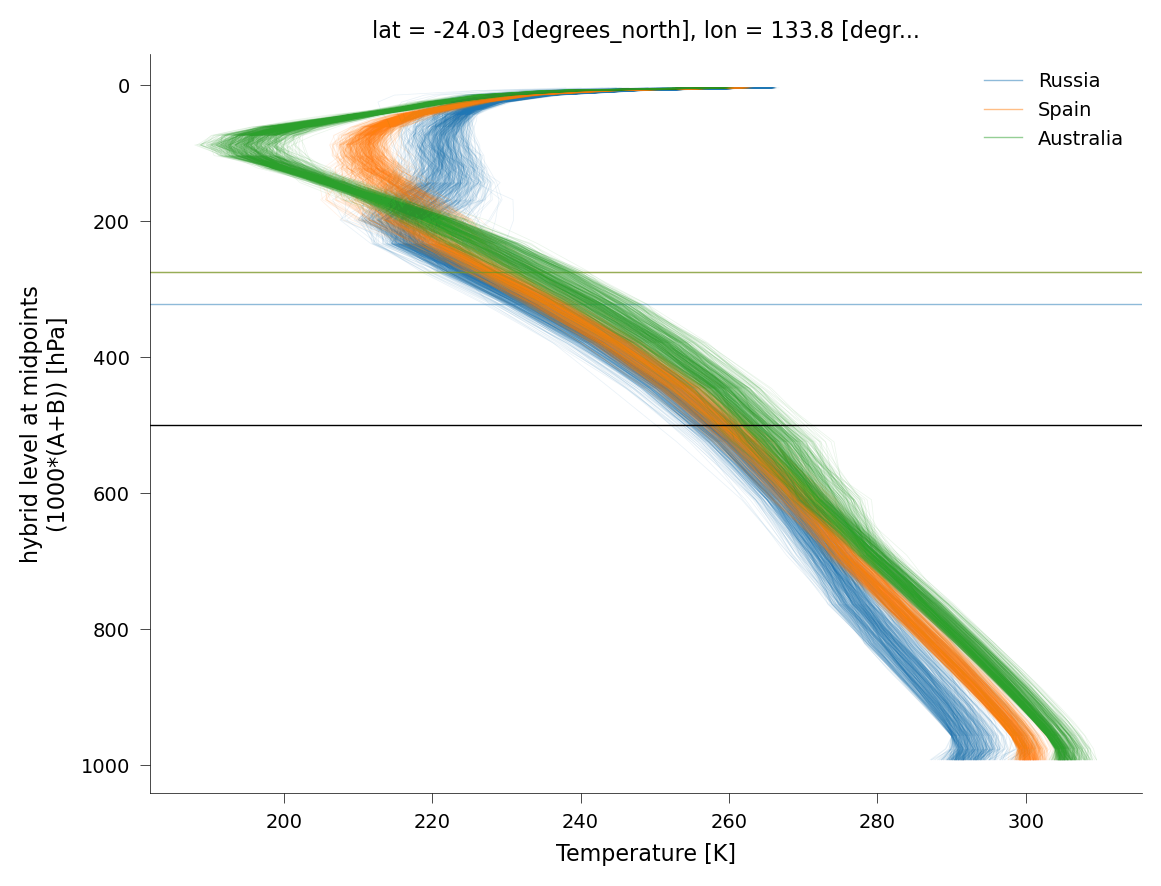

In [10]:
# Sanity check that inversion level looks reasonable
for i in range(n_exp):
    for j in range(n_sample):
        ds_hot.T.isel(loc=i, sample=j).plot(y='lev', color=f'C{i}', lw=ax_linewidth, alpha=0.1)
    plt.axhline(ds_hot.lev.isel(lev=ds_hot['lev_min'][i]), color=f'C{i}', alpha=0.5, label=exp_names[i].capitalize())
plt.gca().invert_yaxis()
plt.axhline(pressure_ft/100, color='k')
plt.legend()
plt.show()

In [11]:
# Only interested between REFHT and LNB, so only use certain levels
if ds_hot.lev.min()<10:          # If have not already done lev slicing, do it here
    if refht_level_index is None or refht_level_index == -1:
        lev_use_max = ds_hot.lev.size
    else:
        lev_use_max = refht_level_index + 1           # don't want to go below our REFHT
    # Only go up to LNB at location with LNB furthest from surface
    ds_hot = ds_hot.isel(lev=slice(int(ds_hot['lev_min'].min()), lev_use_max))
    ds_hot['lev_min'] = ds_hot['lev_min'] - int(ds_hot['lev_min'].min())        # record LNB for each loc relative to new lev
    # Remove levels above LNB for all variables except pressure - CAUSES ISSUES IF Temperature for interpolating
    # for var in ds_hot.data_vars:
    #     if var in ['p', 'T']:
    #         continue        # need to keep pressure to do vectorized calculations
    #     if 'lev' in ds_hot[var].dims:
    #         ds_hot[var] = ds_hot[var].where(ds_hot.lev>=ds_hot.lev.isel(lev=ds_hot.lev_min))
    # ds_hot = ds_hot.isel(lev=slice(int(ds_hot.lev_min.min()), ds_hot.lev.size+10000))
    # ds_hot['p'] = ds_hot.p.where(ds_hot.lev>=ds_hot.lev[ds_hot.lev_min], drop=True)
    # ds_hot['lev_min'] = ds_hot['lev_min'].isel(lev=-1, drop=True).astype(int)       # make ds_hot same as it was initially

In [12]:
ds_hot['p_lcl'], ds_hot['T_lcl'] = lcl_metpy(ds_hot.TREFHT, ds_hot.QREFHT, ds_hot.PREFHT)
ds_hot['T_sqe'] = apply_func_vec(conv_neutral_profile, ds_hot.p, ds_hot.T_lcl, ds_hot.p_lcl)
ds_hot['T_sqe'] = ds_hot['T_sqe'].where(ds_hot.lev >= ds_hot.lev.isel(lev=ds_hot.lev_min))          # only keep profile up to LNB
ds_hot['T_sqe_error'] = np.abs(ds_hot.T - ds_hot['T_sqe']).mean(dim='lev').fillna(np.inf)

In [13]:
ds_hot['const_lapse'] = get_bulk_lapse_rate(ds_hot.TREFHT, ds_hot.T.isel(lev=ds_hot.lev_min), ds_hot.PREFHT,
                                            ds_hot.p.isel(lev=ds_hot.lev_min)) * 1000
ds_hot['T_const_lapse'] = reconstruct_temp(ds_hot.TREFHT, ds_hot.p, ds_hot.p, ds_hot.PREFHT, ds_hot['const_lapse']/1000, ds_hot['const_lapse']/1000)
ds_hot['T_const_lapse'] = ds_hot['T_const_lapse'].where(ds_hot.lev >= ds_hot.lev.isel(lev=ds_hot.lev_min))          # only keep profile up to LNB
ds_hot['T_const_lapse_error'] = np.abs(ds_hot.T - ds_hot['T_const_lapse']).mean(dim='lev').fillna(np.inf)

## SQE2 Fit
The first SQE fit found the LCL using the formula from the REFHT conditions. Here, we find the LCL level with dry adiabat below and saturated moist adiabat above, such that the mean absolute error between this and the actual temperature profile between the REFHT and 300hPa is minimised.

In [14]:
def get_sqe2_prof(temp_refht, p_refht, temp_lev, p_lev, lev_min_index,
                  temp_ft=None, p_ft=None, p_surface=None, hyam=None, hybm=None, plev_step=1000, error_mode='mean'):
    # Returns 2 lapse rate profile, choosing the splitting point to minimise the error
    if 'plev' in temp_lev.coords:
        temp_lev = temp_lev.drop('plev')
    if p_surface is not None:
        if 'plev' in p_surface:
            p_surface = p_surface.drop('plev')
    plevs_split_all = np.arange(round_any(float(p_lev.min()), plev_step, 'floor'),
                                round_any(float(p_lev.max()), plev_step, 'ceil')+plev_step/2, plev_step)
    plevs_split_all = xr.DataArray(plevs_split_all, dims="p_split", name="p_split")
    temp_split_all = dry_profile_temp(temp_refht, p_refht, plevs_split_all)
    # temp_split_all = interp_hybrid_to_pressure(data=temp_lev, ps=p_surface, hyam=hyam, hybm=hybm, p0=p0,
    #                                            new_levels=plevs_split_all.values, lev_dim='lev')
    # temp_split_all = temp_split_all.rename({'plev': 'p_split'})     # must match plevs_split dimension
    # temp_split_all = temp_split_all.load()          # load all first to make quicker
    # temp_lev is temperature at each model level
    T_prof_all = []
    for j in range(plevs_split_all.size):
        T_prof_all.append(apply_func_vec(conv_neutral_profile, p_lev, temp_split_all.isel(p_split=j), plevs_split_all.isel(p_split=j)))
    T_prof_all = xr.concat(T_prof_all, dim=plevs_split_all)

    if temp_ft is not None:
        # Only include splitting levels such that at 500hPa environmental temp is less than SQE temp i.e. CAPE is positive
        T_prof_all_ft = interp_hybrid_to_pressure(data=T_prof_all, ps=p_surface.expand_dims({'p_split': plevs_split_all}), hyam=hyam, hybm=hybm, p0=p0,
                                                   new_levels=np.atleast_1d(p_ft), lev_dim='lev')
        T_prof_all_ft = T_prof_all_ft.isel(plev=0).load()
        T_prof_all = T_prof_all.where(temp_ft < T_prof_all_ft)

    # Only include temperature up to LNB
    T_prof_all = T_prof_all.where(T_prof_all.lev >= T_prof_all.lev.isel(lev=lev_min_index))

    # Find level which minimises error between actual profile and constant lapse profile
    prof_error = getattr(np.abs(temp_lev - T_prof_all), error_mode)(dim='lev').fillna(np.inf)
    ind_split_best = prof_error.argmin(dim='p_split').astype(int)
    ind_split_best = ind_split_best
    temp_prof_best = T_prof_all.isel(p_split=ind_split_best)
    p_split = plevs_split_all.isel(p_split=ind_split_best).where(temp_refht>0)         # where so returns nan if nan
    temp_split = temp_split_all.isel(p_split=ind_split_best).where(temp_refht>0)
    return temp_prof_best, prof_error.isel(p_split=ind_split_best), p_split, temp_split

ds_hot['T_sqe2'], ds_hot['T_sqe2_error'], ds_hot['p_lcl2'], ds_hot['T_lcl2'] = \
    get_sqe2_prof(ds_hot.TREFHT, ds_hot.PREFHT, ds_hot.T, ds_hot.p, ds_hot.lev_min)
# ds_hot['T_sqe2'], ds_hot['T_sqe2_error'], ds_hot['p_lcl2'], ds_hot['T_lcl2'] = \
#     get_sqe2_prof(ds_hot.TREFHT, ds_hot.PREFHT, ds_hot.T, ds_hot.p, ds_hot.lev_min, ds_hot.T500.isel(plev=0),
#                   pressure_ft, ds_hot.PS, ds_hot.hyam, ds_hot.hybm)
ds_hot = ds_hot.drop_vars('p_split')

In [202]:
def get_moist_above_lcl_prof(temp_refht, p_refht, temp_lev, p_lev, lev_min_index, p_surface, hyam, hybm, 
                             temp_ft=None, p_ft=None, plev_step=1000, error_mode='mean'):
    # Returns 2 lapse rate profile, choosing the splitting point to minimise the error
    if 'plev' in temp_lev.coords:
        temp_lev = temp_lev.drop('plev')
    if p_surface is not None:
        if 'plev' in p_surface:
            p_surface = p_surface.drop('plev')
    plevs_split_all = np.arange(round_any(float(p_lev.min()), plev_step, 'floor'),
                                round_any(float(p_lev.max()), plev_step, 'ceil')+plev_step/2, plev_step)
    plevs_split_all = xr.DataArray(plevs_split_all, dims="p_split", name="p_split")
    temp_split_all = interp_hybrid_to_pressure(data=temp_lev, ps=p_surface, hyam=hyam, hybm=hybm, p0=p0,
                                               new_levels=plevs_split_all.values, lev_dim='lev')
    temp_split_all = temp_split_all.rename({'plev': 'p_split'})     # must match plevs_split dimension
    temp_split_all = temp_split_all.load()          # load all first to make quicker
    # temp_lev is temperature at each model level
    T_prof_all = []
    for j in range(plevs_split_all.size):
        T_prof_all.append(apply_func_vec(moist_above_lcl_profile, p_lev, temp_split_all.isel(p_split=j), plevs_split_all.isel(p_split=j), 
                                         temp_refht, p_refht))
    T_prof_all = xr.concat(T_prof_all, dim=plevs_split_all)

    if temp_ft is not None:
        # Only include splitting levels such that at 500hPa environmental temp is less than SQE temp i.e. CAPE is positive
        T_prof_all_ft = interp_hybrid_to_pressure(data=T_prof_all, ps=p_surface.expand_dims({'p_split': plevs_split_all}), hyam=hyam, hybm=hybm, p0=p0,
                                                   new_levels=np.atleast_1d(p_ft), lev_dim='lev')
        T_prof_all_ft = T_prof_all_ft.isel(plev=0).load()
        T_prof_all = T_prof_all.where(temp_ft < T_prof_all_ft)

    # Only include temperature up to LNB
    T_prof_all = T_prof_all.where(T_prof_all.lev >= T_prof_all.lev.isel(lev=lev_min_index))

    # Find level which minimises error between actual profile and constant lapse profile
    prof_error = getattr(np.abs(temp_lev - T_prof_all), error_mode)(dim='lev').fillna(np.inf)
    ind_split_best = prof_error.argmin(dim='p_split').astype(int)
    ind_split_best = ind_split_best
    temp_prof_best = T_prof_all.isel(p_split=ind_split_best)
    p_split = plevs_split_all.isel(p_split=ind_split_best).where(temp_refht>0)         # where so returns nan if nan
    temp_split = temp_split_all.isel(p_split=ind_split_best).where(temp_refht>0)
    return temp_prof_best, prof_error.isel(p_split=ind_split_best), p_split, temp_split

ds_hot['T_sqe3'], ds_hot['T_sqe3_error'], ds_hot['p_lcl3'], ds_hot['T_lcl3'] = \
    get_moist_above_lcl_prof(ds_hot.TREFHT, ds_hot.PREFHT, ds_hot.T, ds_hot.p, ds_hot.lev_min, ds_hot.PS, ds_hot.hyam, ds_hot.hybm)
# ds_hot['T_sqe2'], ds_hot['T_sqe2_error'], ds_hot['p_lcl2'], ds_hot['T_lcl2'] = \
#     get_sqe2_prof(ds_hot.TREFHT, ds_hot.PREFHT, ds_hot.T, ds_hot.p, ds_hot.lev_min, ds_hot.T500.isel(plev=0),
#                   pressure_ft, ds_hot.PS, ds_hot.hyam, ds_hot.hybm)
ds_hot = ds_hot.drop_vars('p_split')

In [15]:
def get_best_lev_split_prof(temp_refht, p_refht, temp_lev, p_lev, p_surface, lev_min_index, hyam, hybm, plev_step=1000, error_mode='mean'):
    # Returns 2 lapse rate profile, choosing the splitting point to minimise the error
    if 'plev' in temp_lev.coords:
        temp_lev = temp_lev.drop('plev')
    if 'plev' in p_surface:
        p_surface = p_surface.drop('plev')
    plevs_split_all = np.arange(round_any(float(p_lev.min()), plev_step, 'floor'),
                                round_any(float(p_lev.max()), plev_step, 'ceil')+plev_step/2, plev_step)
    plevs_split_all = xr.DataArray(plevs_split_all, dims="p_split", name="p_split")
    temp_split_all = interp_hybrid_to_pressure(data=temp_lev, ps=p_surface, hyam=hyam, hybm=hybm, p0=p0,
                                               new_levels=plevs_split_all.values, lev_dim='lev')
    temp_split_all = temp_split_all.rename({'plev': 'p_split'})     # must match plevs_split dimension
    temp_split_all = temp_split_all.load()          # load all first to make quicker
    # temp_lev is temperature at each model level
    # error_mode is way to quantify error between actual profile and constant lapse profile across all levels
    lapse_below_all = get_bulk_lapse_rate(temp_refht, temp_split_all, p_refht,
                                          plevs_split_all.expand_dims({key: temp_refht[key] for key in temp_refht.dims})) * 1000
    lapse_above_all = get_bulk_lapse_rate(temp_split_all, temp_lev.isel(lev=lev_min_index),
                                          plevs_split_all.expand_dims({key: temp_refht[key] for key in temp_refht.dims}),
                                          p_lev.isel(lev=lev_min_index)) * 1000
    T_prof_all = []
    for j in range(plevs_split_all.size):
        T_prof_all.append(apply_func_vec(const_lapse_lcl_profile, p_lev, temp_refht, p_refht, temp_split_all.isel(p_split=j),
                                         plevs_split_all.isel(p_split=j), lapse_below_all.isel(p_split=j), lapse_above_all.isel(p_split=j)))
    T_prof_all = xr.concat(T_prof_all, dim=plevs_split_all)

    # Only include temperature up to LNB
    T_prof_all = T_prof_all.where(T_prof_all.p_split <= p_refht)        # Split level must be above REFHT
    T_prof_all = T_prof_all.where(T_prof_all.p_split >= p_lev.min(dim='lev'))    # Split level must be below min pressure
    T_prof_all = T_prof_all.where(T_prof_all.lev >= T_prof_all.lev.isel(lev=lev_min_index))

    # Find level which minimises error between actual profile and constant lapse profile
    prof_error = getattr(np.abs(temp_lev - T_prof_all), error_mode)(dim='lev', skipna=True).fillna(np.inf)
    ind_split_best = prof_error.argmin(dim='p_split').astype(int)
    # lev_split_best = argmin_with_nan
    temp_prof_best = T_prof_all.isel(p_split=ind_split_best, drop=True)
    p_split = plevs_split_all.isel(p_split=ind_split_best, drop=True).where(temp_refht>0)         # where so returns nan if nan
    temp_split = temp_split_all.isel(p_split=ind_split_best, drop=True).where(temp_refht>0)
    return temp_prof_best, prof_error.isel(p_split=ind_split_best), p_split, temp_split

In [16]:
ds_hot['T_const_lapse2'], ds_hot['T_const_lapse2_error'], ds_hot['const_lapse2_p_split'], ds_hot['const_lapse2_T_split'] = \
    get_best_lev_split_prof(ds_hot.TREFHT, ds_hot.PREFHT,
                            ds_hot.T, ds_hot.p, ds_hot.PS, ds_hot.lev_min, ds_hot.hyam, ds_hot.hybm)
ds_hot = ds_hot.drop_vars('p_split')

### Example Profile
Simple visual comparison of how good an approximation the SQE profile is to the environmental profile. While the SQE3 profile is more accurate, the SqE2 profile seems to be the best representation of what convection wants the profile to look like i.e. there is CIN due to lapse rate being less than the dry adiabat. There is CAPE at 500hPa, with T500 < T500_sqe2.

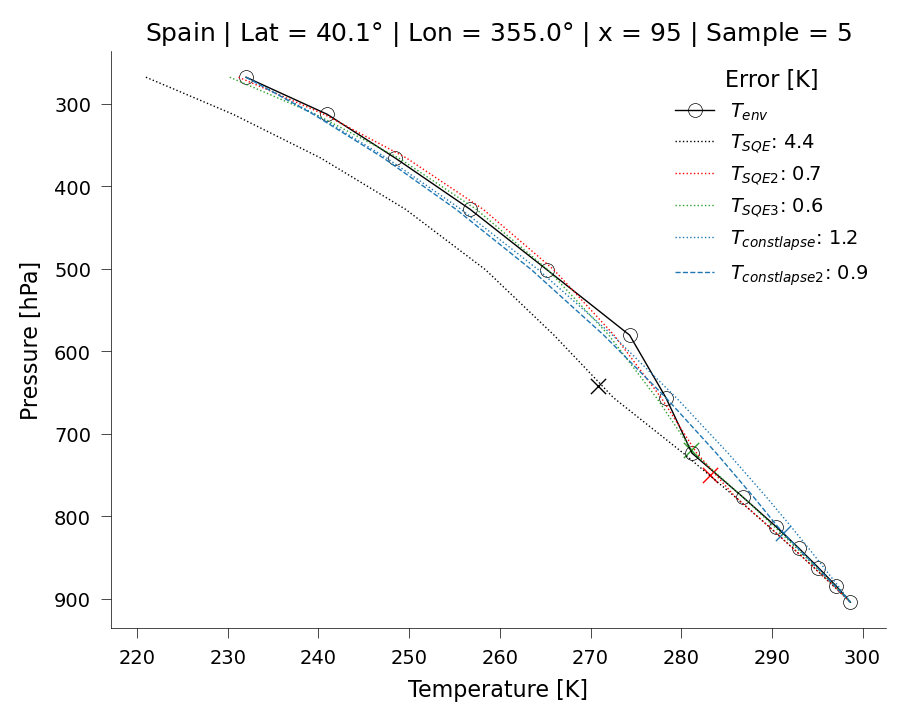

In [324]:
i = 5
loc_plot = 'spain'
ds_use = ds_hot.isel(sample=i).sel(loc=loc_plot)
fig, ax = plt.subplots(1, 1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
ax.plot(ds_use.T, ds_use.p / 100, color='k', label='$T_{env}$', marker='o', markerfacecolor='none', markeredgecolor='k', markersize=5)

ax.plot(ds_use.T_sqe, ds_use.p / 100, linestyle=':', color='k', label='$T_{SQE}$' + f': {ds_use.T_sqe_error:.1f}')
ax.scatter(ds_use.T_lcl, ds_use.p_lcl / 100, marker='x', color='k', s=30)
ax.plot(ds_use.T_sqe2, ds_use.p / 100, linestyle=':', color='r', label='$T_{SQE2}$' + f': {ds_use.T_sqe2_error:.1f}')
ax.scatter(ds_use.T_lcl2, ds_use.p_lcl2 / 100, marker='x', color='r', s=30)
ax.plot(ds_use.T_sqe3, ds_use.p / 100, linestyle=':', color='C2', label='$T_{SQE3}$' + f': {ds_use.T_sqe3_error:.1f}')
ax.scatter(ds_use.T_lcl3, ds_use.p_lcl3 / 100, marker='x', color='C2', s=30)
ax.plot(ds_use.T_const_lapse, ds_use.p / 100, linestyle=':', color='C0',
        label='$T_{constlapse}$' + f': {ds_use.T_const_lapse_error:.1f}')
ax.plot(ds_use.T_const_lapse2, ds_use.p / 100, linestyle='--', color='C0',
        label='$T_{constlapse2}$' + f': {ds_use.T_const_lapse2_error:.1f}')
ax.scatter(ds_use.const_lapse2_T_split, ds_use.const_lapse2_p_split / 100, marker='x', color='C0', s=30)
ax.legend(title='Error [K]')
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("Pressure [hPa]")
ax.set_title(
    f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ |'
    f' x = {quant} | Sample = {i}', y=0.99, fontsize=9)
plt.gca().invert_yaxis()


### LCL vs CAPE relation
Below we see that the optimal LCL, $p_{LCL2}$ is closer to (further from) the surface when the CAPE proxy is negative (positive) indicating more moist (dry) conditions than may be expected from the REFHT conditions.

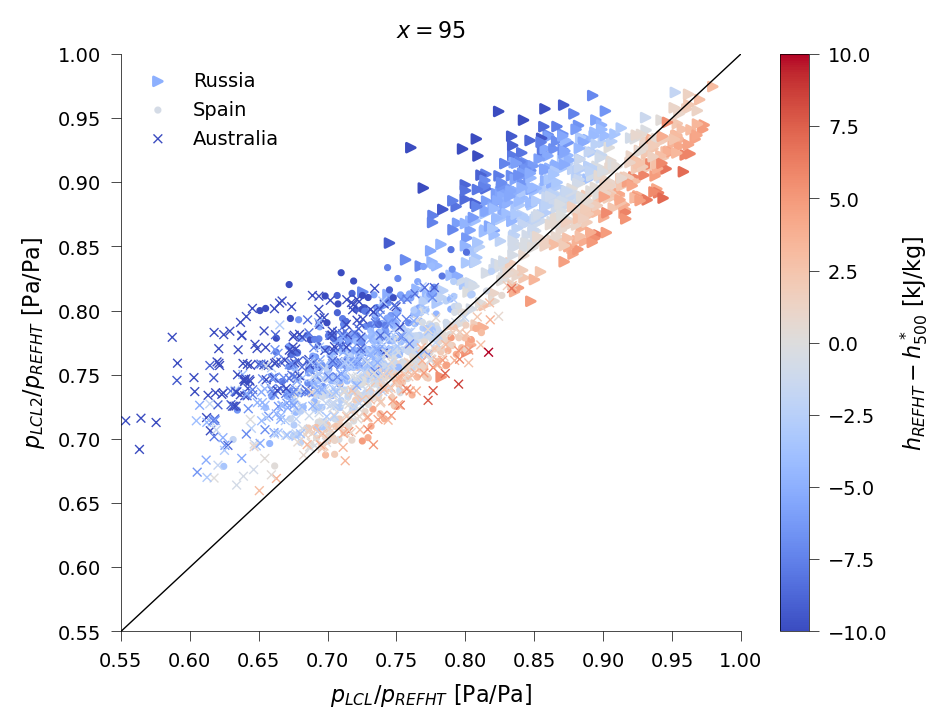

In [37]:
fig, ax = plt.subplots(1, 1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)
for i in range(n_exp):
    im = ax.scatter((ds_hot.p_lcl/ds_hot.PREFHT).isel(loc=i), (ds_hot.p_lcl2/ds_hot.PREFHT).isel(loc=i),
                c=(ds_hot.mse_REFHT-ds_hot.mse_sat_500).isel(loc=i), cmap='coolwarm', vmin=-10, vmax=10, marker=['>', '.', 'x'][i], s=10,
               label=exp_names[i].capitalize())
ax.legend()
ax.plot([0.55, 1], [0.55, 1], color='k')
ax.set_xlabel("$p_{LCL}/p_{REFHT}$ [Pa/Pa]")
ax.set_ylabel("$p_{LCL2}/p_{REFHT}$ [Pa/Pa]")
plt.colorbar(im, ax=ax, label='$h_{REFHT} - h_{500}^*$ [kJ/kg]')
ax.set_xlim(0.55, 1)
ax.set_ylim(0.55, 1)
ax.set_title(f'$x={quant}$')
plt.show()

### Better temperature profile fit for SQE2
Below we see that SQE2 is the same as SQE below the LCL. But the $T_{env} - T_{SQE2}$ plot looks more like we would expect in a convective regime: CIN below LCL with $T_{env} > T_{SQE2}$ and CAPE above LCL, with $T_{env} < T_{SQE2}$. Then at very high altitudes, $T_{env} > T_{SQE2}$ again, as we are above the LZB.

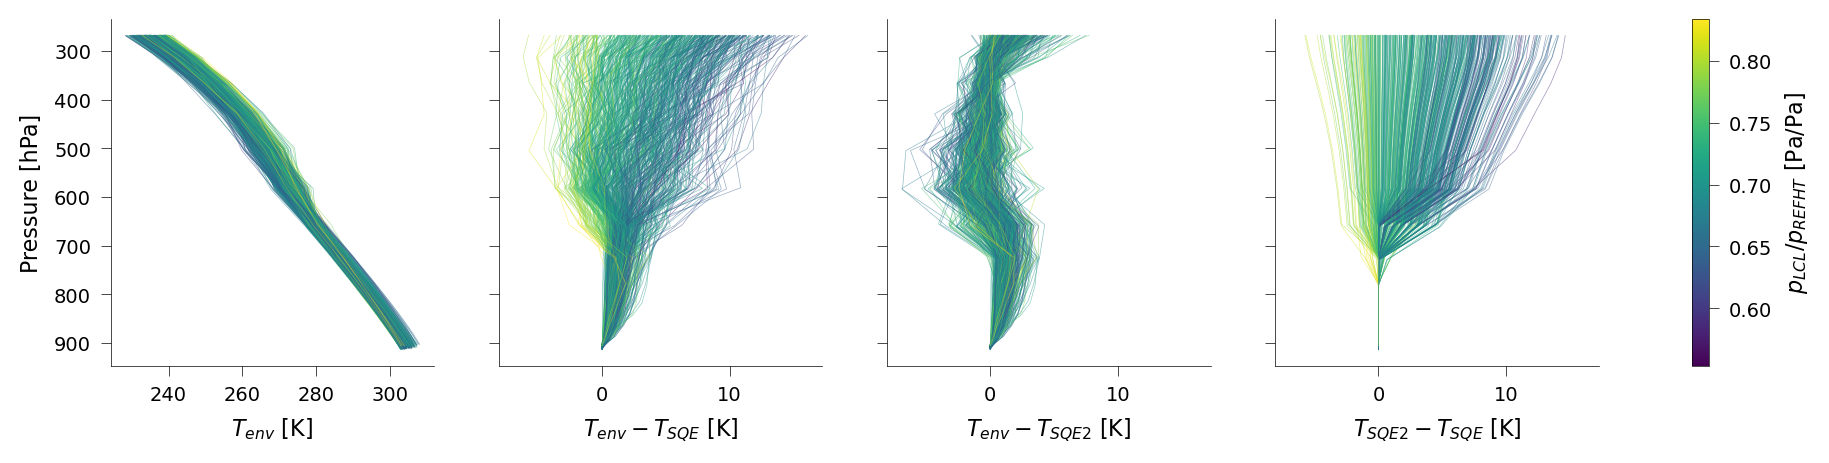

In [38]:
loc_plot = 'australia'
ds_use = ds_hot.sel(loc=loc_plot)
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=(ds_use.p_lcl/ds_use.PREFHT).min(), vmax=(ds_use.p_lcl/ds_use.PREFHT).max())
fig, ax = plt.subplots(1, 4, sharey=True)
isca_tools.plot.fig_resize(fig, 12)
for i in range(n_sample):
    # if i not in [234, 276]:
    #     continue
    # if (ds_use.mse_REFHT - ds_use.mse_sat_500).isel(sample=i) < 4:
    #     continue
    ax[0].plot(ds_use.T.isel(sample=i), ds_use.p.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])), lw=ax_linewidth, alpha=0.5)
    # ax[0].plot(ds_use.T_conv_neutral.isel(sample=i), ds_use.p.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #            lw=1, alpha=0.5, linestyle=':')
    # ax[0].scatter(ds_use.T_lcl.isel(sample=i), ds_use.p_lcl.isel(sample=i)/100, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])),
    #               marker='_', lw=1, s=60)
    ax[1].plot(ds_use.T.isel(sample=i) -ds_use.T_sqe.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
    ax[2].plot(ds_use.T.isel(sample=i) - ds_use.T_sqe2.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
    ax[3].plot(ds_use.T_sqe2.isel(sample=i) - ds_use.T_sqe.isel(sample=i), ds_use.p.isel(sample=i)/100,
               lw=ax_linewidth, alpha=0.5, c=cmap(norm(ds_use.p_lcl[i]/ds_use.PREFHT[i])))
ax[0].invert_yaxis()
ax[2].sharex(ax[1])
ax[3].sharex(ax[1])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="$p_{LCL}/p_{REFHT}$ [Pa/Pa]", ax=ax.ravel())
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$T_{env}$ [K]')
ax[1].set_xlabel('$T_{env} - T_{SQE}$ [K]')
ax[2].set_xlabel('$T_{env} - T_{SQE2}$ [K]')
ax[3].set_xlabel('$T_{SQE2} - T_{SQE}$ [K]')
# fig.suptitle(f'{loc_plot.capitalize()} | Lat = {ds.lat.sel(loc=loc_plot):.1f}$\degree$ | Lon = {ds.lon.sel(loc=loc_plot):.1f}$\degree$ |'
#              f' x = {quant} | {n_resample} Day Avg', y=0.98, fontsize=9)
plt.show()

## Error reduction of SQE2 and SQE3
This section compares how well different profile constructions reproduce the environmental temperature profile.

- Scatter panels compare mean absolute errors, ⟨|T_env − T_model|⟩, for SQE, SQE2, SQE3, and two constant‑lapse baselines. A 1:1 line helps identify which method performs better; colors denote locations and the subplot titles show the percentile x.
- A follow‑up plot contrasts the optimal lifting‑condensation pressures, p_{LCL3} vs p_{LCL2}, both normalized by p_{REFHT}, to illustrate how the best split level shifts between the SQE variants.

Use these to see where SQE2/SQE3 reduce error relative to SQE and constant‑lapse fits, and how their inferred LCLs differ.


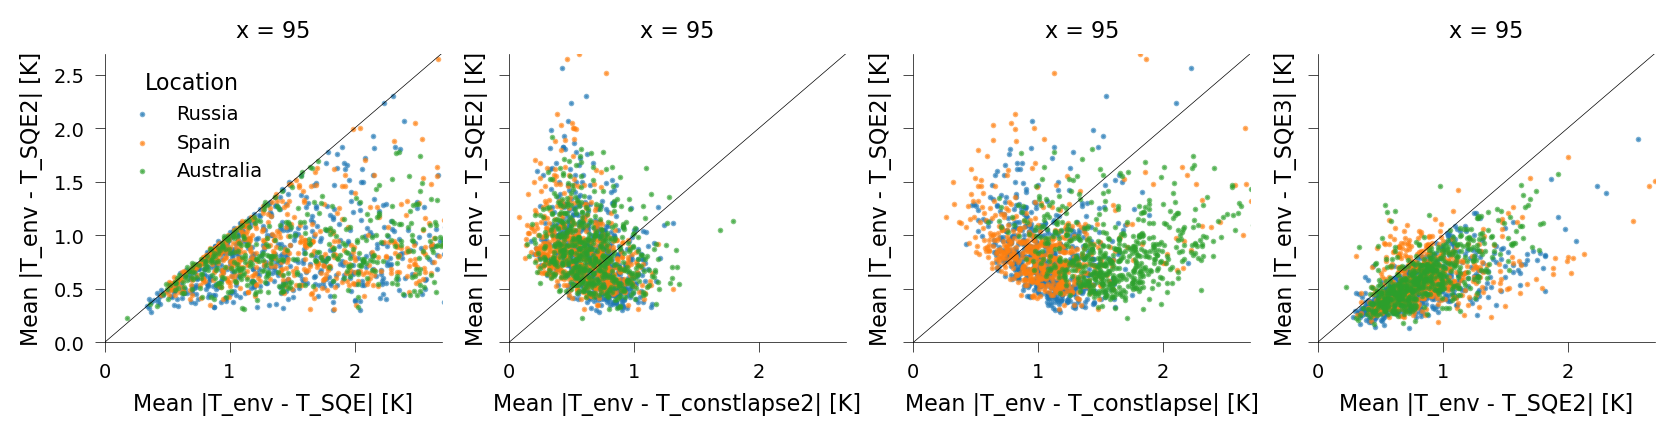

In [326]:
# Prepare errors per method
err_sqe_all = ds_hot['T_sqe_error']
err_sqe2_all = ds_hot['T_sqe2_error']
err_sqe3_all = ds_hot['T_sqe3_error']
err_const_all = ds_hot['T_const_lapse_error']
err_const2_all = ds_hot['T_const_lapse2_error']

# Create subplots: 4 comparisons in one figure
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 10)

comparisons = [
    (err_sqe_all, err_sqe2_all, 'Mean |T_env - T_SQE| [K]', 'Mean |T_env - T_SQE2| [K]'),
    (err_const2_all, err_sqe2_all, 'Mean |T_env - T_constlapse2| [K]', 'Mean |T_env - T_SQE2| [K]'),
    (err_const_all, err_sqe2_all, 'Mean |T_env - T_constlapse| [K]', 'Mean |T_env - T_SQE2| [K]'),
    (err_sqe2_all, err_sqe3_all, 'Mean |T_env - T_SQE2| [K]', 'Mean |T_env - T_SQE3| [K]'),
]

for k, (xerrs, yerrs, xlabel, ylabel) in enumerate(comparisons):
    m = 0.0
    for i in range(n_exp):
        x = xerrs.isel(loc=i).values
        y = yerrs.isel(loc=i).values
        mask = np.isfinite(x) & np.isfinite(y)
        ax[k].scatter(x[mask], y[mask], s=1, alpha=0.6, color=f'C{i}', label=exp_names[i].capitalize())
        if mask.any():
            m = max(m, float(np.nanmax(x[mask])), float(np.nanmax(y[mask])))
    # 1:1 line and axes formatting
    ax[k].plot([0, m], [0, m], color='k', lw=ax_linewidth)
    ax[k].set_xlabel(xlabel)
    ax[k].set_ylabel(ylabel)
    ax[k].set_xlim(0, m)
    ax[k].set_ylim(0, m)
    ax[k].set_title(f'x = {quant}')

# Single legend for all subplots (from the first axis)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, title='Location')

plt.show()


### Compare LCL levels for SQE2 and SQE3
the LCL3 is always further from the surface than LCL2, because the lapse rate is less than the dry adiabat.

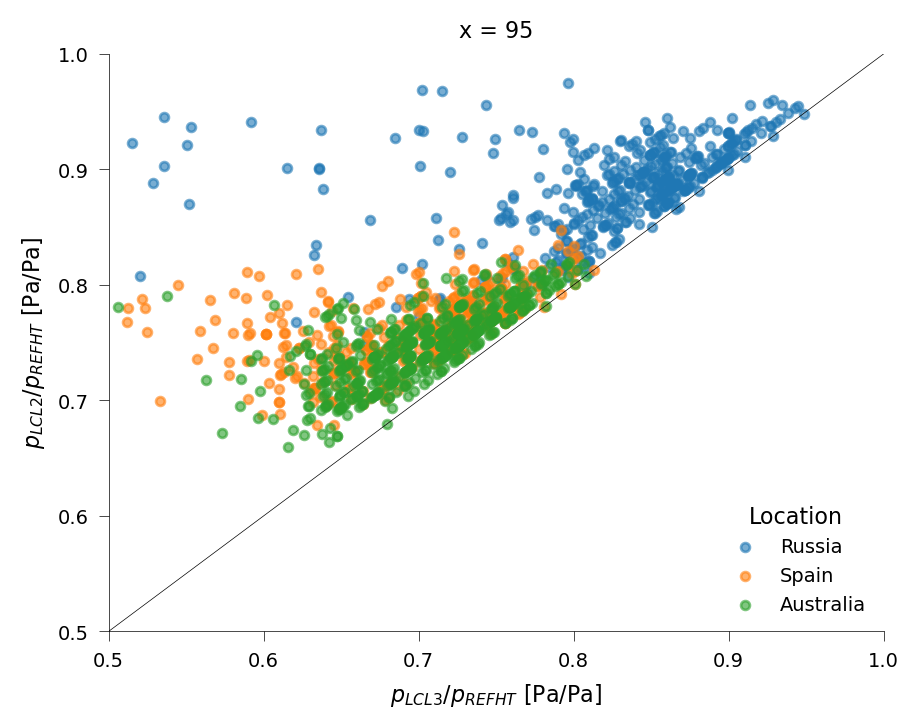

In [220]:
fig, ax = plt.subplots(1, 1, sharey=True)
isca_tools.plot.fig_resize(fig, 5)

for i in range(n_exp):
    x = (ds_hot.p_lcl3 / ds_hot.PREFHT).isel(loc=i).values
    y = (ds_hot.p_lcl2 / ds_hot.PREFHT).isel(loc=i).values
    m = np.isfinite(x) & np.isfinite(y)
    if m.any():
        ax.scatter(x[m], y[m], s=10, alpha=0.6, color=f"C{i}", label=exp_names[i].capitalize())

# 1:1 reference line and formatting
ax.plot([0.5, 1.0], [0.5, 1.0], color='k', lw=ax_linewidth)
ax.set_xlim(0.5, 1.0)
ax.set_ylim(0.5, 1.0)
ax.set_xlabel("$p_{LCL3}/p_{REFHT}$ [Pa/Pa]")
ax.set_ylabel("$p_{LCL2}/p_{REFHT}$ [Pa/Pa]")
ax.set_title(f"x = {quant}")
ax.legend(title="Location")
plt.show()


### PCA Exploratory Ananlysis
Below I look at which variables are correlated, and so suitable for PCA.

In [80]:
exp_quant_path = f'/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/pre_industrial/all_days/output_lev_quant{quant}.nd2'
ds_use = xr.open_dataset(exp_quant_path).isel(quant=0)
ds_use = lat_lon_coord_slice(ds_use, ds_hot.lat.values, ds_hot.lon.values)
ds_use = ds_use.rename({'location': 'loc'})
ds_use = ds_use.load()

# Sanity check that pointing to correct days
T500_error = float(np.abs(ds_hot.T500 - ds_use.T_anom - ds_use.T_zonal_av).max())

if T500_error < 0.1:
    ds_hot['T500_zonal_av'] = ds_use['T_zonal_av']
    ds_hot['T500_zonal_anom'] = ds_use['T_anom']
else:
    raise ValueError('T500_zonal_av and T500_zonal_anom are not the same as the T500_zonal_av and T500_zonal_anom in the hottest location')

In [90]:
# Compute temp at LCL2 for a CIN proxy
ds_use = interp_var_at_pressure(ds_hot.T, ds_hot.p_lcl2, ds_hot.PS,
                                ds_hot.hyam, ds_hot.hybm, p0)
ds_hot['T_at_lcl2'] = ds_use.T
ds_hot['p_at_lcl2'] = ds_use.plev.transpose()
ds_hot = ds_hot.load()

# Compute SQE2 temp at 500hPa for CAPE proxy
ds_hot['T500_sqe2'] = interp_hybrid_to_pressure(data=ds_hot.T_sqe2, ps=ds_hot.PS, hyam=ds_hot.hyam, hybm=ds_hot.hybm, p0=p0, 
                                   new_levels=np.atleast_1d(pressure_ft), lev_dim='lev')
ds_hot = ds_hot.load()

In [193]:
ds_hot['lapse_below_lcl2'] = get_bulk_lapse_rate(ds_hot['TREFHT'], ds_hot['T_at_lcl2'], ds_hot['PREFHT'], ds_hot['p_at_lcl2']) * 1000

In [130]:
ds_hot['rh_REFHT'] = ds_hot['QREFHT'] / sphum_sat(ds_hot['TREFHT'], ds_hot['PREFHT'])
ds_hot['QREFHT2'] = sphum_sat(ds_hot['T_lcl2'], ds_hot['p_lcl2'])       # effective sphum following SQE2 is that which is saturated at LCL2
var = lcl_metpy(ds_hot['TREFHT'], ds_hot['QREFHT2'], ds_hot['PREFHT'])
# Sanity check that QREFHT2 calculated in correct way to give LCL following SQE2
print(f'p_lcl2 error using QREFHT2: {float(np.abs(var[0] - ds_hot.p_lcl2).max()):.2g} Pa')
print(f'T_lcl2 error using QREFHT2: {float(np.abs(var[1] - ds_hot.T_lcl2).max()):.2g} K')
ds_hot['rh_REFHT2'] = ds_hot['QREFHT2'] / sphum_sat(ds_hot['TREFHT'], ds_hot['PREFHT'])

p_lcl2 error using QREFHT2: 0.51 Pa
T_lcl2 error using QREFHT2: 0.00045 K


In [327]:
# plt.scatter(lapse_dry*1000-ds_hot['lapse_below_lcl2'], ds_hot['rh_REFHT2'], s=1, alpha=0.5)

In [167]:
diff_rh = ds_hot["rh_REFHT"] - ds_hot["rh_REFHT2"]
diff_rh = diff_rh.rename("rh_REFHT - rh_REFHT2")

vars_to_plot_ext = [
    ("T500_zonal_av", ds_hot["T500_zonal_av"]),
    ("T500_zonal_anom", ds_hot["T500_zonal_anom"]),
    ("rh_REFHT2", ds_hot["rh_REFHT2"]),
    ("rh_REFHT - rh_REFHT2", diff_rh),
    ("T500 - T500_sqe2", ds_hot["T500"].isel(plev=0) - ds_hot["T500_sqe2"].isel(plev=0)),
    ("T_at_lcl2 - T_lcl2", ds_hot["T_at_lcl2"] - ds_hot["T_lcl2"]),
]


In [168]:
sqe2_error_thresh = 1
mask_days = ds_hot['T_sqe2_error'] < sqe2_error_thresh
vars_to_plot_ext = [(name, da.where(mask_days)) for name, da in vars_to_plot_ext]


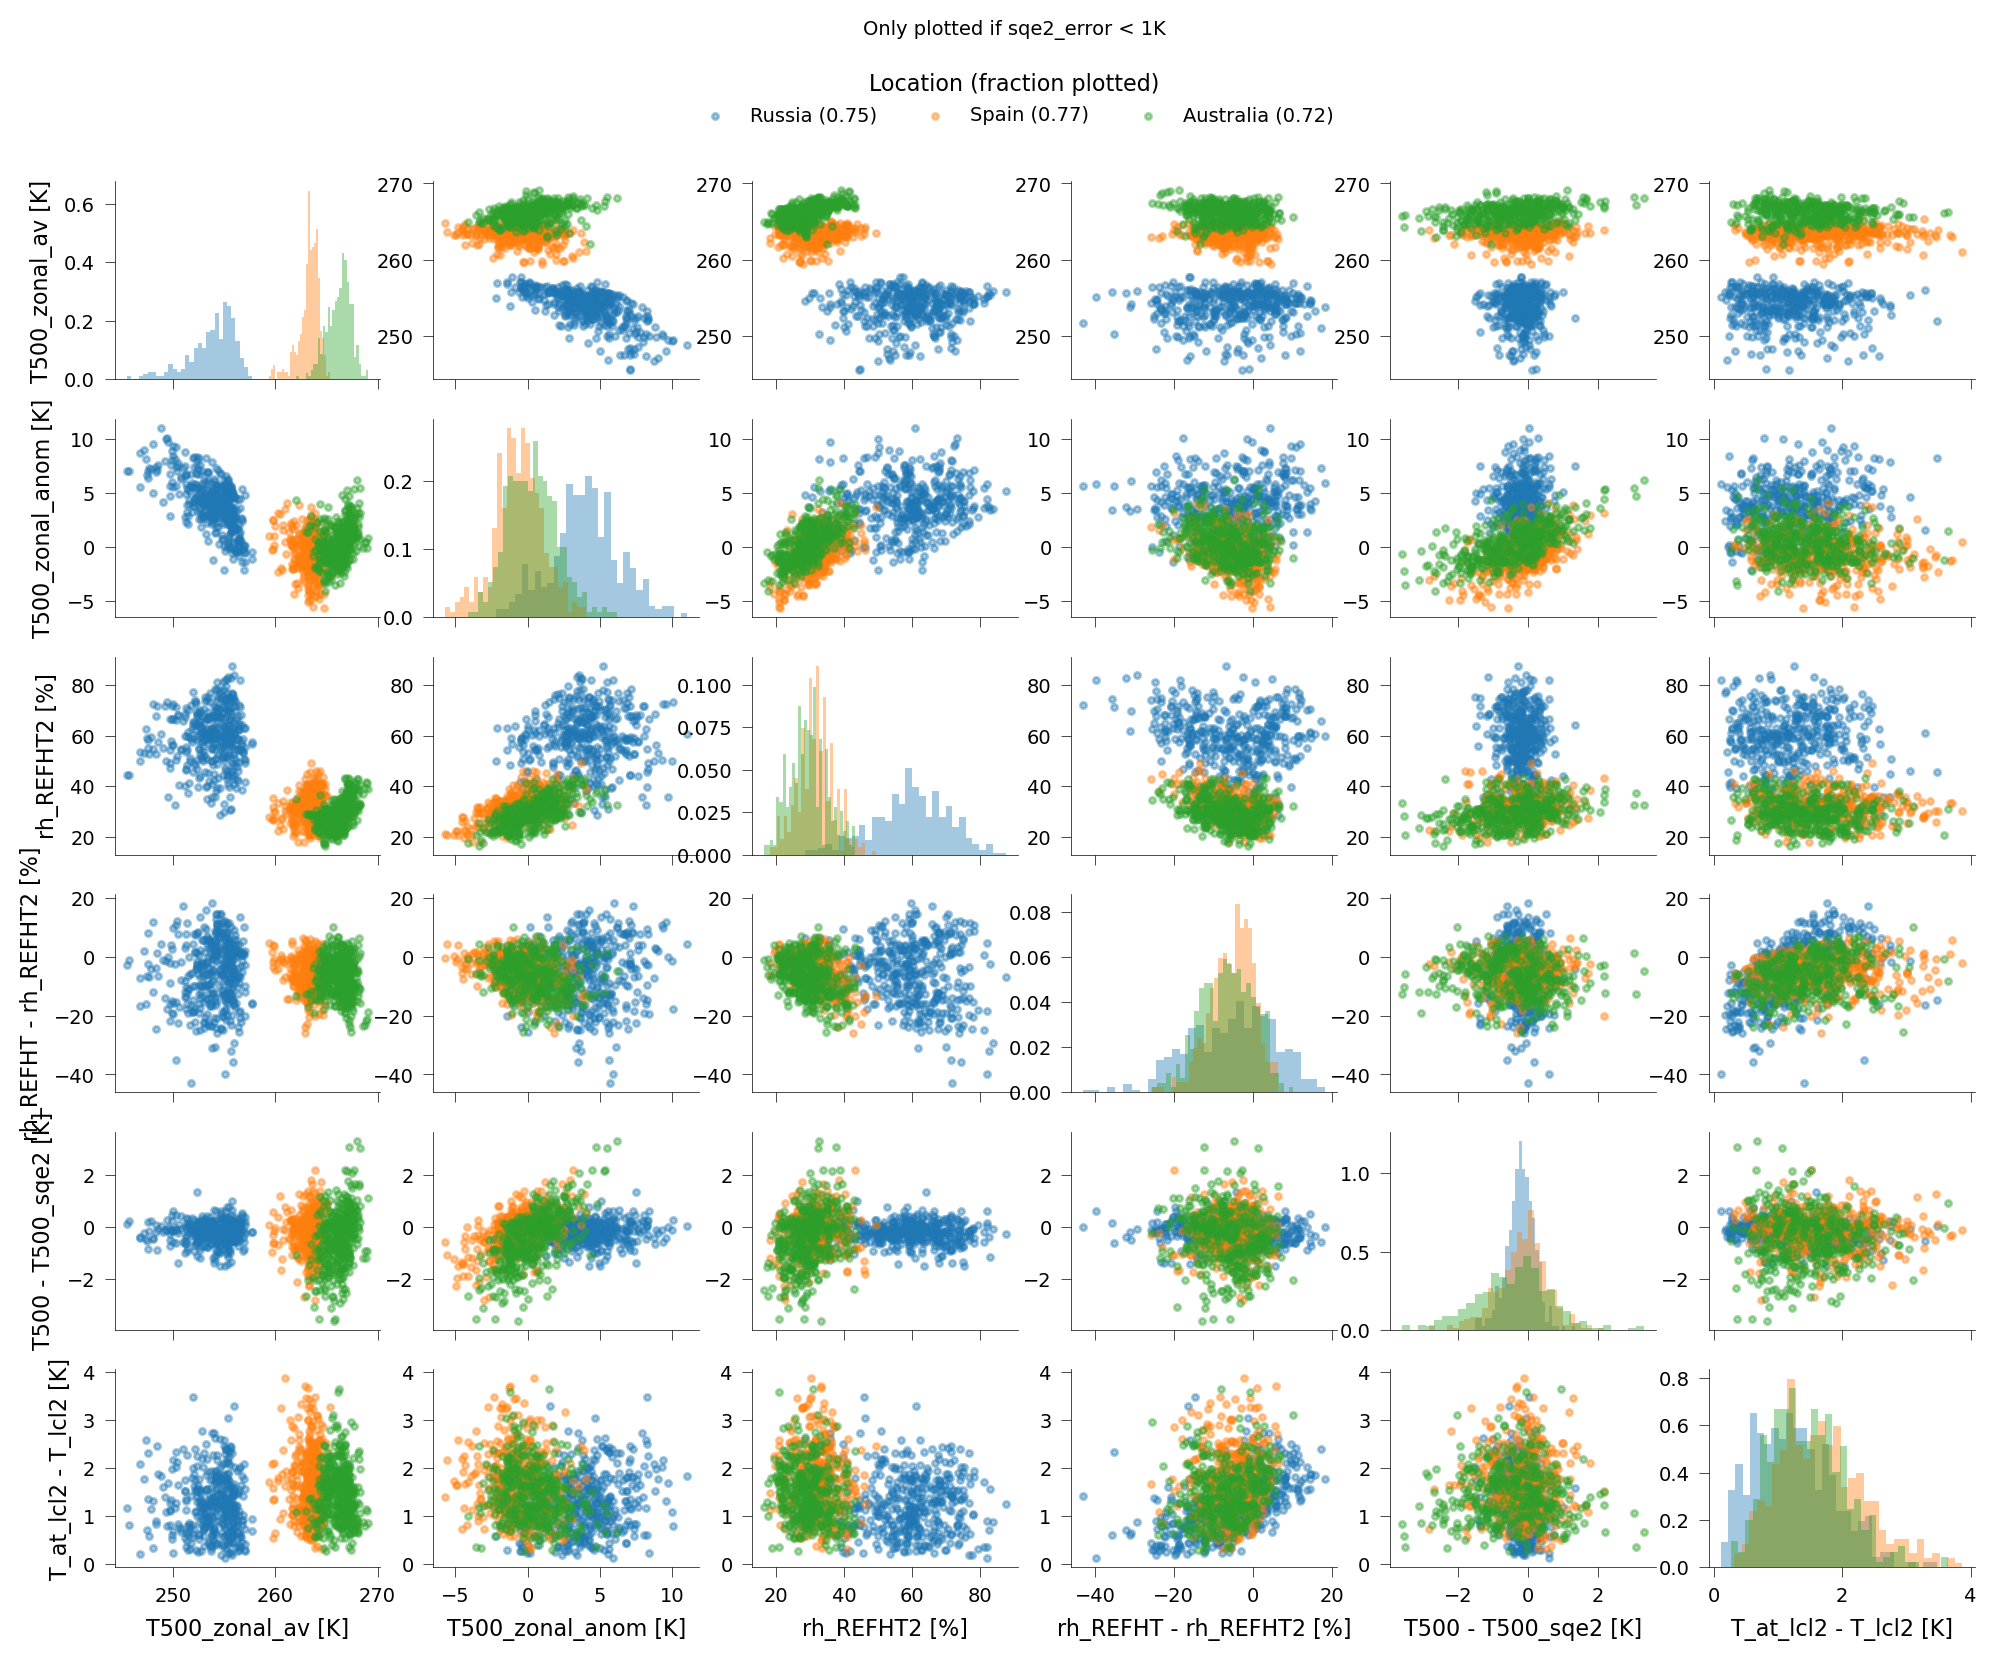

In [169]:
n_ext = len(vars_to_plot_ext)
fig, axes = plt.subplots(n_ext, n_ext, sharex='col')
isca_tools.plot.fig_resize(fig, 12)

# Prepare data and labels with units; convert RH to %
vars_to_plot_ext_with_units = []
for name, da in vars_to_plot_ext:
    if 'rh' in name.lower():
        vars_to_plot_ext_with_units.append((f"{name} [%]", da * 100))
    else:
        vars_to_plot_ext_with_units.append((f"{name} [K]", da))

# Compute fraction of masked days per location
frac_mask_by_loc = [float(mask_days.isel(loc=li).mean().values) for li in range(n_exp)]

for i in range(n_ext):
    for j in range(n_ext):
        ax = axes[i, j]
        if i == j:
            for li in range(n_exp):
                v = vars_to_plot_ext_with_units[i][1].isel(loc=li).values
                v = v[np.isfinite(v)]
                ax.hist(v, bins=30, color=f"C{li}", alpha=0.4, density=True)
        else:
            for li in range(n_exp):
                x = vars_to_plot_ext_with_units[j][1].isel(loc=li).values
                y = vars_to_plot_ext_with_units[i][1].isel(loc=li).values
                m = np.isfinite(x) & np.isfinite(y)
                if m.any():
                    ax.scatter(
                        x[m], y[m], s=5, alpha=0.4, color=f"C{li}",
                        label=(f"{exp_names[li].capitalize()} ({frac_mask_by_loc[li]:.2f})"
                               if (i == 0 and j == 1) else None)
                    )
        if i == n_ext - 1:
            ax.set_xlabel(vars_to_plot_ext_with_units[j][0])
        else:
            ax.set_xlabel("")
        if j == 0:
            ax.set_ylabel(vars_to_plot_ext_with_units[i][0])
        else:
            ax.set_ylabel("")
        ax.tick_params(width=ax_linewidth)

handles, labels = axes[0, 1].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncol=n_exp, title="Location (fraction plotted)",
               bbox_to_anchor=(0.5, 0.95))

fig.suptitle(f"Only plotted if sqe2_error < {sqe2_error_thresh}K", y=0.97)
plt.show()


### Correlation between variables

Based on the correlation heatmap (Pearson r):

- Strong negative correlations:
  - T500_zonal_av vs rh_REFHT2 (r ≈ −0.80)
  - T500_zonal_av vs T500_zonal_anom (r ≈ −0.70)

Other pairs show weaker or mixed correlations (|r| < 0.5).


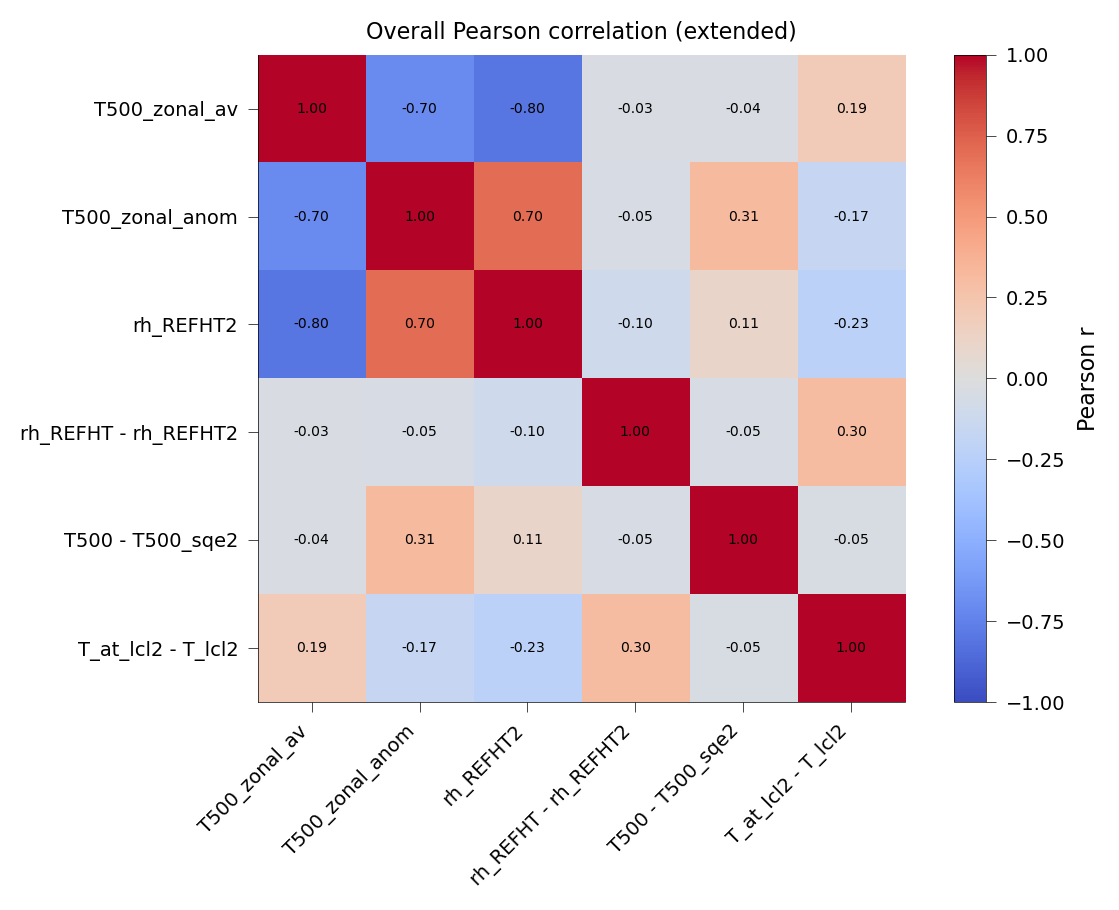

In [170]:
var_names_ext = [v[0] for v in vars_to_plot_ext]
vals_all_ext = {name: [] for name in var_names_ext}

for name, da in vars_to_plot_ext:
    for li in range(n_exp):
        arr = da.isel(loc=li).values
        m = np.isfinite(arr)
        vals_all_ext[name].append(arr[m])

for name in var_names_ext:
    vals_all_ext[name] = np.concatenate(vals_all_ext[name], axis=0)


def compute_corr_df_ext(vals_dict, names, method="pearson"):
    n = len(names)
    mat = np.full((n, n), np.nan, dtype=float)
    for a in range(n):
        xa = np.asarray(vals_dict[names[a]])
        for b in range(n):
            xb = np.asarray(vals_dict[names[b]])
            m = np.isfinite(xa) & np.isfinite(xb)
            if m.sum() > 2:
                if method == "pearson":
                    r = np.corrcoef(xa[m], xb[m])[0, 1]
                else:
                    r, _ = sts.spearmanr(xa[m], xb[m])
                mat[a, b] = r
    return pd.DataFrame(mat, index=names, columns=names)


corr_overall_pearson_ext = compute_corr_df_ext(vals_all_ext, var_names_ext, method="pearson")

fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 6)
im = ax.imshow(corr_overall_pearson_ext.values, vmin=-1, vmax=1, cmap='coolwarm')
ax.set_xticks(range(len(var_names_ext)));
ax.set_xticklabels(var_names_ext, rotation=45, ha='right')
ax.set_yticks(range(len(var_names_ext)));
ax.set_yticklabels(var_names_ext)
for i in range(len(var_names_ext)):
    for j in range(len(var_names_ext)):
        val = corr_overall_pearson_ext.values[i, j]
        if np.isfinite(val):
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=SMALL_SIZE)
plt.colorbar(im, ax=ax, label='Pearson r')
ax.set_title('Overall Pearson correlation (extended)')
plt.tight_layout()
plt.show()


In [310]:
var_pca = ['T500_zonal_av', 'T500_zonal_anom', 'rh_REFHT2']
var_other = ['T_at_lcl2', 'T_lcl2', 'T500', 'T500_sqe2', 'rh_REFHT', 'TREFHT']

# Build full arrays first
X_full = np.column_stack([ds_hot[key].where(mask_days).values.flatten() for key in var_pca])
X_loc_full = ds_hot['loc'].where(mask_days).values.flatten()
X_other = np.column_stack([ds_hot[key].where(mask_days).values.flatten() for key in var_other])

# Base mask: finite on first column
mask = np.isfinite(X_full[:, 0])

# Option to restrict by location (set to 'russia' to enable, or None to disable)
select_loc = None
if select_loc is not None:
    mask = mask & (X_loc_full == select_loc)

# Apply mask
X = X_full[mask]
X_loc = X_loc_full[mask]
X_other = X_other[mask]

In [284]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = [np.full_like(X[i], np.nan) for i in range(n_exp)]
X_scaled = scaler.fit_transform(X)

# X_lat = (0*ds.dayofyear.isel(co2=ind_pca_exp).fillna(0) + ds.lat).values.flatten()
# X_lon = (0*ds.dayofyear.isel(co2=ind_pca_exp).fillna(0) + ds.lon).values.flatten()

In [285]:
n_comp = 3
pca = PCA(n_components=n_comp)
X_pca = np.full((X.shape[0], n_comp), np.nan)
X_pca = pca.fit_transform(X_scaled)

loadings = pca.components_.T  # shape: (variables, components)

for i, pc_loadings in enumerate(loadings.T, 1):
    print(f"\nPC{i} loadings (var explained = {pca.explained_variance_ratio_[i-1]:.2f}):")
    for var, loading in zip(var_pca, pc_loadings):
        print(f"  {var:20s}: {loading:.2f}")
#
# # Apply PCA found using ind_pca_exp to other exps
# for i in range(n_exp):
#     if i == ind_pca_exp:
#         continue
#     X_scaled[i][keep_ind[i]] = scaler.transform(X[i][keep_ind[i]])          # normalise according to that of ind_pca_exp
#     X_pca[i][keep_ind[i]] = pca.transform(X_scaled[i][keep_ind[i]])         # find coefficients in PC space of ind_pca_exp


PC1 loadings (var explained = 0.82):
  T500_zonal_av       : -0.59
  T500_zonal_anom     : 0.56
  rh_REFHT2           : 0.59

PC2 loadings (var explained = 0.11):
  T500_zonal_av       : 0.39
  T500_zonal_anom     : 0.83
  rh_REFHT2           : -0.40

PC3 loadings (var explained = 0.07):
  T500_zonal_av       : -0.71
  T500_zonal_anom     : -0.00
  rh_REFHT2           : -0.71


### PCA Results

Task: Contrast Russia, Spain, and Australia by how their hot‑day samples distribute in PC space and what the PCs represent.

PC interpretation (from loadings and explained variance):
- PC1 (≈82% var): higher with warmer‑than‑zonal 500 hPa anomalies and higher near‑surface saturation (rh_REFHT2), and lower climatological 500 hPa temperature.
  - Physically: “dynamically warm aloft anomaly + moist boundary layer on a climatologically cooler‑aloft background.”
- PC2 (≈11% var): higher with strong positive 500 hPa anomalies but drier near‑surface (negative rh_REFHT2 loading).
  - Physically: “upper‑level warming anomaly with comparatively dry low levels.”

Location differences in PC1–PC2:
- Russia:
  - Tends toward higher PC1 on hottest days: large positive T500 anomalies over a climatologically cooler‑aloft background, with relatively moist boundary layer (high rh_REFHT2).
  - PC2 generally moderate to low: upper‑level warming is present but not accompanied by pronounced drying at the surface.
- Spain:
  - Lower PC1 on average: warmer climatological 500 hPa background and comparatively lower rh_REFHT2 reduce PC1.
  - Moderate PC2: hot events mix moist and dry boundary‑layer conditions; not as consistently “dry‑aloft‑warm” as Australia.
- Australia:
  - Intermediate PC1: mixes of background state and moisture lead to PC1 values between Russia and Spain.
  - Higher PC2: hot events often feature strong upper‑level warming with a drier boundary layer.

Summary:
- PC1 separates “moist, dynamically warm anomalies on cooler‑aloft backgrounds” (Russia high) from “drier/warmer‑aloft backgrounds” (Spain low; Australia mid).
- PC2 highlights “dry‑hot aloft events” (Australia higher) versus “moister hot events” (Russia lower; Spain mixed).


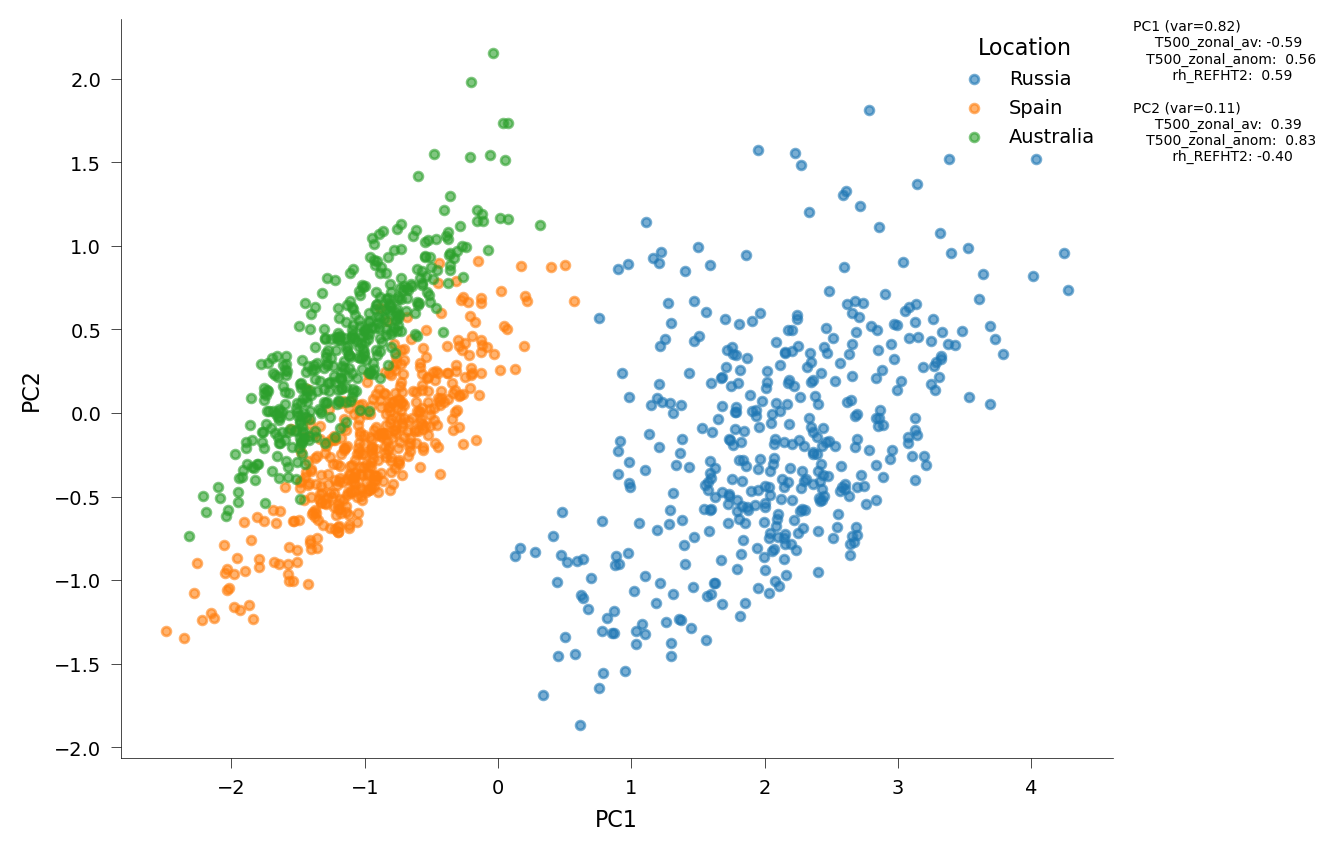

In [286]:
for i, loc_name in enumerate(exp_names):
    m = X_loc == loc_name
    plt.scatter(X_pca[m, 0], X_pca[m, 1], s=10, alpha=0.6, color=f"C{i}", label=loc_name.capitalize())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Location")

# Add text box with PC loadings for PC1 and PC2
pc_text_lines = []
for comp in range(min(2, loadings.shape[1])):  # only PC1 and PC2
    pc_header = f"PC{comp + 1} (var={pca.explained_variance_ratio_[comp]:.2f})"
    var_lines = [f"  {var_pca[v]:>16s}: {loadings[v, comp]: .2f}" for v in range(loadings.shape[0])]
    pc_text_lines.append(pc_header + "\n" + "\n".join(var_lines))
pc_text = "\n\n".join(pc_text_lines)

ax = plt.gca()
ax.text(1.02, 1.0, pc_text, transform=ax.transAxes, va='top', ha='left', fontsize=SMALL_SIZE,
        family=plt.rcParams['font.family'])
plt.show()

### TREFHT dependence on PCs
It seems that TREFHT increases as PC1 becomes more negative, and PC2 becomes more positive.

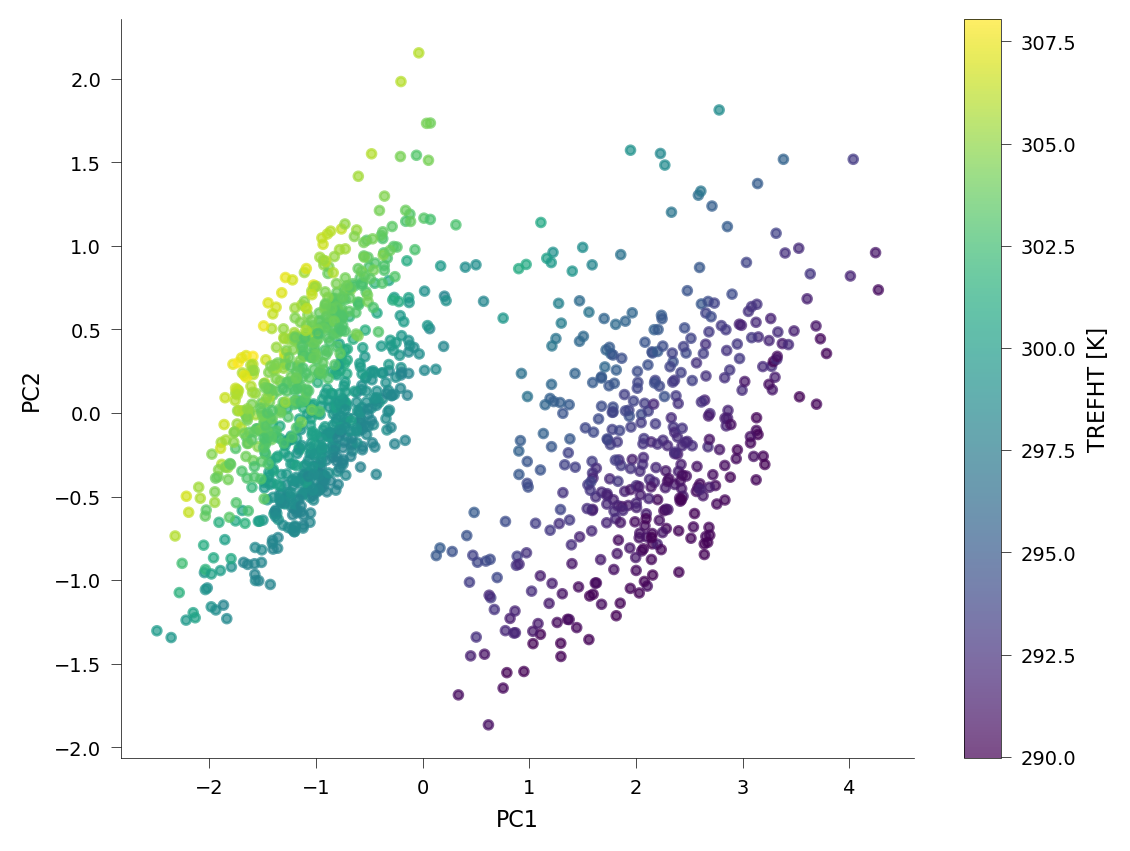

In [314]:
# Scatter PC1 vs PC2 colored by rh_REFHT2 - rh_REFHT using aligned rows from X (var_pca) and X_other
c_vals =  X_other[:, -1] - 0*X[:, 2]    # rh_REFHT (from X_other) minus rh_REFHT2 (from var_pca)
# c_vals =  X_other[:, 0] - X_other[:, 1]    # rh_REFHT (from X_other) minus rh_REFHT2 (from var_pca)
m = np.nanmax(np.abs(c_vals))

plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.7, c=c_vals, vmax=m)
plt.xlabel("PC1")
plt.ylabel("PC2")
cb = plt.colorbar()
cb.set_label("TREFHT [K]")

# Add text box with PC loadings for PC1 and PC2
pc_text_lines = []
for comp in range(min(2, loadings.shape[1])):  # only PC1 and PC2
    pc_header = f"PC{comp + 1} (var={pca.explained_variance_ratio_[comp]:.2f})"
    var_lines = [f"  {var_pca[v]:>16s}: {loadings[v, comp]: .2f}" for v in range(loadings.shape[0])]
    pc_text_lines.append(pc_header + "\n" + "\n".join(var_lines))
pc_text = "\n\n".join(pc_text_lines)

ax = plt.gca()
# ax.text(1.02, 1.0, pc_text, transform=ax.transAxes, va='top', ha='left', fontsize=SMALL_SIZE,
#         family=plt.rcParams['font.family'])
plt.show()